# World University Ranking – Linear Regression Project

Dataset source: **aritra100/world-university-ranking** on Kaggle

We use linear regression model to predict the final grade of a student.

## 1  Setup & download

In [205]:
%pip install -q --upgrade kagglehub pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\49665\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Download dataset. Remove first column "Student ID" and last column "Pass/Fail."

In [206]:
import kagglehub
import pandas as pd, numpy as np, os, glob

DATA_PATH = kagglehub.dataset_download("amrmaree/student-performance-prediction")
csv_file = glob.glob(os.path.join(DATA_PATH, "*.csv"))
df = pd.read_csv(csv_file[0])
df = df.drop(columns=['Student_ID', 'Pass_Fail'])
df.head()

,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score
0,Male,31,68.267841,86,High School,Yes,Yes,63
1,Male,16,78.222927,73,PhD,No,No,50
2,Female,21,87.525096,74,PhD,Yes,No,55
3,Female,27,92.076483,99,Bachelors,No,No,65
4,Female,37,98.655517,63,Masters,No,Yes,70


Split the column that will be predicted.

In [207]:
y = df['Final_Exam_Score']
X = df.drop(columns=['Final_Exam_Score'])

## 2  Exploratory Data Analysis (EDA)

### Dataset dimensions and dtypes

In [208]:
print(f"Rows: {X.shape[0]:,}")
print(f"Columns: {X.shape[1]}")
X.dtypes

Rows: 708
Columns: 7


Gender                         object
Study_Hours_per_Week            int64
Attendance_Rate               float64
Past_Exam_Scores                int64
Parental_Education_Level       object
Internet_Access_at_Home        object
Extracurricular_Activities     object
dtype: object

### Statistics

In [209]:
X.describe(percentiles=[0.25, 0.5, 0.75], include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,708,2,Female,375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Study_Hours_per_Week,708.0,NaN,NaN,NaN,26.132768,8.877727,10.0,19.0,27.0,34.0,39.0
Attendance_Rate,708.0,NaN,NaN,NaN,78.107722,13.802802,50.11697,67.550094,79.363046,89.504232,99.967675
Past_Exam_Scores,708.0,NaN,NaN,NaN,77.871469,14.402739,50.0,65.0,79.0,91.0,100.0
Parental_Education_Level,708,4,Bachelors,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Internet_Access_at_Home,708,2,No,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extracurricular_Activities,708,2,No,361,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Correlation matrix

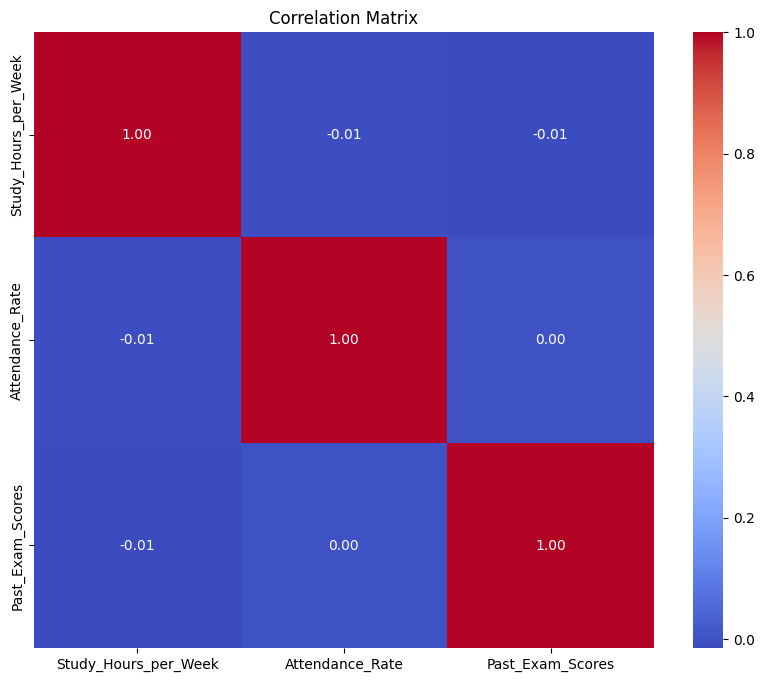

In [210]:
import matplotlib.pyplot as plt, seaborn as sns

corr = X.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix');

### Missing‑value inspection

In [211]:
missing = X.isna().sum().sort_values(ascending=False)
missing

Gender                        0
Study_Hours_per_Week          0
Attendance_Rate               0
Past_Exam_Scores              0
Parental_Education_Level      0
Internet_Access_at_Home       0
Extracurricular_Activities    0
dtype: int64

No missing values, so no action needed.

### Outlier check (IQR)

In [212]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

def iqr_outliers(feature):
    q1, q3 = feature.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return feature[(feature < lower) | (feature > upper)]

outlier_counts = {col: len(iqr_outliers(df[col])) for col in numeric_features}
outlier_counts

{'Study_Hours_per_Week': 0, 'Attendance_Rate': 0, 'Past_Exam_Scores': 0}

## 3  Modelling

### Training

In [213]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown="error"))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train);

### Model coefficients

In [214]:
reg = model.named_steps['reg']
print('Intercept:', reg.intercept_)
print('Coefficients:', reg.coef_)

Intercept: 58.81222403317859
Coefficients: [ 2.43628168  3.1110801   3.41195983 -0.04252367  0.04252367  0.48543256
 -0.73703907  0.15949314  0.09211337  0.42899726 -0.42899726 -0.42362495
  0.42362495]


### Error metrics

In [215]:
import math

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(f"MAE: {mae:.3f}\nMSE: {mse:.3f}\nRMSE: {rmse:.3f}")

MAE: 3.158
MSE: 14.792
RMSE: 3.846


### Data visualisation

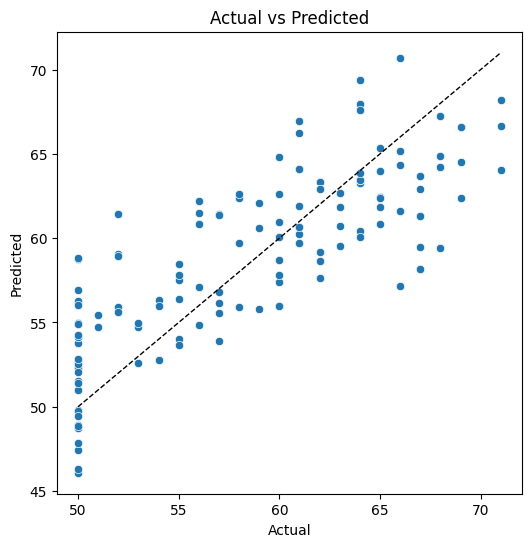

In [216]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted');

## 4  Conclusion

Our model is decent (MAE and RMSE are about 3 or 4 while predicting grades in the interval 50-70). However, it badly predicts 50. The reason may be the fact that the grade system was not properly presented by the author of the dataset (50 is probably the minimal possible grade, but our model can predict 45 too). The dataset had no missing values and no outliers which is a good sign.